In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy
from multiprocessing import Pool, shared_memory
from scipy.ndimage import gaussian_filter

mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"

from common_func import *

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [2]:
LG = pklload(f"{database}/LG")
allsubs = None
states = None
for key in LG.keys():
    subs = LG[key]['subs']
    real = LG[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs = subs if allsubs is None else np.hstack((allsubs, subs))
    states = state if states is None else np.hstack((states, state))
argsort = np.argsort(allsubs['id'])
allsubs = allsubs[argsort]
states = states[argsort]

In [3]:
import healpy as hp

In [4]:
LG = pklload(f"{database}/LG")

In [5]:
LG[1]['BGG'].dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

In [9]:
def show_mollview(key, LG, snap, center=0, nside=64, drawsat=False, drawgas=False, drawcold=False, cic=False, reverse=False):
    BGG = LG[key]['BGG']
    stars = pklload(f"./database/parts/nh_star_{key:04d}.pickle")
    stars = uri.Particle(stars,snap)
    rband = measure_luminosity(stars, 'SDSS_r')
    if(drawgas):
        cells = pklload(f"./database/parts/nh_cell_{key:04d}.pickle")
        cells = uri.Cell(cells,snap)

    center_pos = np.array([BGG['x'], BGG['y'], BGG['z']])
    if(center>0):
        x, y, z = BGG['x'],BGG['y'],BGG['z']  # Example values, replace with your actual data
        Lx, Ly, Lz = BGG['Lx'],BGG['Ly'],BGG['Lz']  # Example values, replace with your actual data
        L = np.array([Lx, Ly, Lz])
        L_norm = L / np.linalg.norm(L)

        V = np.cross(L_norm, np.array([0, 1, 0]))
        if np.all(V == 0):  # If L was along y, choose a different vector
            V = np.cross(L_norm, np.array([0, 0, 1]))

        V_norm = V / np.linalg.norm(V) * center*snap.unit['kpc']  # Scale to 8 kpc
        center_pos = np.array([x, y, z]) + V_norm
    
    if(drawsat):
        sats = LG[key]['sats']
        sats = sats[sats['id']>0]
        pid = uhmi.HaloMaker.read_member_parts(snap, sats, galaxy=True, simple=True)['id']
    
    centerstar = np.argmin(np.sqrt((stars['x']-BGG['x'])**2 + (stars['y']-BGG['y'])**2 + (stars['z']-BGG['z'])**2))
    x = stars['x'] - center_pos[0]
    y = stars['y'] - center_pos[1]
    z = stars['z'] - center_pos[2]
    r = np.sqrt(x**2 + y**2 + z**2)

    rx,ry,rz = rot(BGG['Lx'],BGG['Ly'],BGG['Lz'], x[centerstar],y[centerstar],z[centerstar])
    gamma = np.arctan2(ry, rx)[0]
    rx,ry,rz = rot(BGG['Lx'],BGG['Ly'],BGG['Lz'], x,y,z, gamma=gamma)
    DEC = np.arcsin(rz / r)  # Declination
    RA = np.arctan2(ry, rx)   # Right Ascension
    RA[RA < 0] += 2 * np.pi

    ims = []
    cmap_bgg = plt.cm.Greys_r if(not reverse) else plt.cm.Greys
    cmap_sat = cmr.nuclear if(not reverse) else cmr.nuclear_r
    cmap_cell = plt.cm.copper if(not reverse) else plt.cm.copper_r
    tmap = drawer.make_cmap([[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 112/255], [25/255, 191/255, 255/255], [255/255, 255/255, 255/255]], position=[0, 0.25, 0.5,0.8,1])
    tmap_r = drawer.make_cmap([[255/255, 255/255, 255/255], [25/255, 191/255, 255/255], [25/255, 25/255, 112/255], [2/255,2/255,25/255], [0,0,0]], position=[0, 0.25, 0.5,0.8,1])
    cmap_cold = tmap if(not reverse) else tmap_r
    cmaps = []
    qscales = [] # [4.5,4.5,2, 2.5]
    vmaxs = [] # [np.nanmax(im_bgg), np.nanmax(im_sat), np.nanmax(im_cell)*15, np.nanmax(im_cold)]
    if(drawsat):
        mask = isin(np.abs(stars['id']), pid)
        # Satellites
        indices = hp.ang2pix(nside, np.pi/2 - DEC[mask], RA[mask]) 
        hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
        for m, ind in tqdm(zip(rband[mask], indices), total=np.sum(mask), desc='Satellites'):
            hpxmap[ind] += m 
        im_sat = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
        ims.append(im_sat); cmaps.append(cmap_sat); qscales.append(4.5); vmaxs.append(np.nanmax(im_sat))
        plt.close()

        # BGG
        indices = hp.ang2pix(nside, np.pi/2 - DEC[~mask], RA[~mask])  # theta = pi/2 - DEC, phi = RA
        hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
        for m, ind in tqdm(zip(rband[~mask], indices), total=np.sum(~mask), desc='BGG'):
            hpxmap[ind] += m  # Increment count in each pixel
        im_bgg = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
        ims.append(im_bgg); cmaps.append(cmap_bgg); qscales.append(4.5); vmaxs.append(np.nanmax(im_bgg))
        plt.close()
    else:
        # All
        indices = hp.ang2pix(nside, np.pi/2 - DEC, RA)  # theta = pi/2 - DEC, phi = RA
        hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
        for m, ind in tqdm(zip(rband, indices), total=len(stars), desc='Stars'):
            hpxmap[ind] += m  # Increment count in each pixel
        im_star = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
        ims.append(im_star); cmaps.append(cmap_bgg); qscales.append(4.5); vmaxs.append(np.nanmax(im_star))
        plt.close()

    if(drawgas):
        x = cells['x'] - center_pos[0]
        y = cells['y'] - center_pos[1]
        z = cells['z'] - center_pos[2]
        T = cells['T','K']
        M = cells['m']
        LEVEL = cells['level']
        if(cic):
            lvls = np.unique(cells['level'])
            for lvl in tqdm(lvls):
                if(lvl==np.max(lvls)): continue
                dx = 1 / (2**lvl)
                mask = LEVEL==lvl
                where = np.where(mask)[0]
                newleng = len(where) * 8
                nx = np.zeros(newleng); ny = np.zeros(newleng); nz = np.zeros(newleng)
                for i in range(8):
                    nx[i::8] = x[where] + dx*(i%2) - dx/2
                    ny[i::8] = y[where] + dx*((i//2)%2) - dx/2
                    nz[i::8] = z[where] + dx*((i//4)%2) - dx/2
                nT = np.zeros(newleng); nM = np.zeros(newleng); nLEVEL = np.zeros(newleng)
                for i in range(8):
                    nT[i::8] = T[where]
                    nM[i::8] = M[where]/8
                    nLEVEL[i::8] = LEVEL[where]*2
                x = np.hstack((x[~mask],nx)); y = np.hstack((y[~mask],ny)); z = np.hstack((z[~mask],nz))
                T = np.hstack((T[~mask],nT)); M = np.hstack((M[~mask],nM)); LEVEL = np.hstack((LEVEL[~mask],nLEVEL))
                
        r = np.sqrt(x**2 + y**2 + z**2)
        rx,ry,rz = rot(BGG['Lx'],BGG['Ly'],BGG['Lz'], x,y,z, gamma=170/180*np.pi)
        DEC = np.arcsin(rz / r)  # Declination
        RA = np.arctan2(ry, rx)   # Right Ascension
        RA[RA < 0] += 2 * np.pi
        if(drawcold):
            mask = (T<2e4)
            indices = hp.ang2pix(nside, np.pi/2 - DEC[~mask], RA[~mask]) 
            hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
            for m, ind in tqdm(zip(M[~mask], indices), total=np.sum(~mask), desc='Hot Gas'):
                hpxmap[ind] += m 
            im_cell = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
            im_cell = gaussian_filter(im_cell, sigma=2)
            ims.append(im_cell); cmaps.append(cmap_cell); qscales.append(1.8); vmaxs.append(np.nanmax(im_cell)*8)
            plt.close()
            
            indices = hp.ang2pix(nside, np.pi/2 - DEC[mask], RA[mask]) 
            hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
            for m, ind in tqdm(zip(M[mask], indices), total=np.sum(mask), desc='Cold Gas'):
                hpxmap[ind] += m 
            im_cold = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
            ims.append(im_cold); cmaps.append(cmap_cold); qscales.append(3.5); vmaxs.append(np.nanmax(im_cold))
            plt.close()
        else:
            indices = hp.ang2pix(nside, np.pi/2 - DEC, RA) 
            hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
            for m, ind in tqdm(zip(M, indices), total=len(M), desc='Gas'):
                hpxmap[ind] += m 
            im_cell = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
            im_cell = gaussian_filter(im_cell, sigma=2)
            plt.close()
            ims.append(im_cell); cmaps.append(cmap_cell); qscales.append(2); vmaxs.append(np.nanmax(im_cell))
    

    composite = painter.composite_image(
            ims, 
            cmaps=cmaps,
            qscales=qscales,
            mode='screen',
            vmaxs = vmaxs
            )
    return composite

In [17]:
key=8
drawgas = True
BGG = LG[key]['BGG']
stars = pklload(f"./database/parts/nh_star_{key:04d}.pickle")
stars = uri.Particle(stars,snap)
rband = measure_luminosity(stars, 'SDSS_r')
if(drawgas):
    cells = pklload(f"./database/parts/nh_cell_{key:04d}.pickle")
    cells = uri.Cell(cells,snap)


In [18]:
center = 8
center_pos = np.array([BGG['x'], BGG['y'], BGG['z']])
if(center>0):
    x, y, z = BGG['x'],BGG['y'],BGG['z']  # Example values, replace with your actual data
    Lx, Ly, Lz = BGG['Lx'],BGG['Ly'],BGG['Lz']  # Example values, replace with your actual data
    L = np.array([Lx, Ly, Lz])
    L_norm = L / np.linalg.norm(L)

    V = np.cross(L_norm, np.array([0, 1, 0]))
    if np.all(V == 0):  # If L was along y, choose a different vector
        V = np.cross(L_norm, np.array([0, 0, 1]))

    V_norm = V / np.linalg.norm(V) * center*snap.unit['kpc']  # Scale to 8 kpc
    center_pos = np.array([x, y, z]) + V_norm

drawsat = False
if(drawsat):
    sats = LG[key]['sats']
    sats = sats[sats['id']>0]
    pid = uhmi.HaloMaker.read_member_parts(snap, sats, galaxy=True, simple=True)['id']

In [19]:
reverse=False
nside=128

centerstar = np.argmin(np.sqrt((stars['x']-BGG['x'])**2 + (stars['y']-BGG['y'])**2 + (stars['z']-BGG['z'])**2))
x = stars['x'] - center_pos[0]
y = stars['y'] - center_pos[1]
z = stars['z'] - center_pos[2]
r = np.sqrt(x**2 + y**2 + z**2)

rx,ry,rz = rot(BGG['Lx'],BGG['Ly'],BGG['Lz'], x[centerstar],y[centerstar],z[centerstar])
gamma = np.arctan2(ry, rx)[0]
rx,ry,rz = rot(BGG['Lx'],BGG['Ly'],BGG['Lz'], x,y,z, gamma=gamma)
DEC = np.arcsin(rz / r)  # Declination
RA = np.arctan2(ry, rx)   # Right Ascension
RA[RA < 0] += 2 * np.pi

In [20]:
ims = []
cmap_bgg = plt.cm.Greys_r if(not reverse) else plt.cm.Greys
cmap_sat = cmr.nuclear if(not reverse) else cmr.nuclear_r
cmap_cell = plt.cm.copper if(not reverse) else plt.cm.copper_r
tmap = drawer.make_cmap([[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 112/255], [25/255, 191/255, 255/255], [255/255, 255/255, 255/255]], position=[0, 0.25, 0.5,0.8,1])
tmap_r = drawer.make_cmap([[255/255, 255/255, 255/255], [25/255, 191/255, 255/255], [25/255, 25/255, 112/255], [2/255,2/255,25/255], [0,0,0]], position=[0, 0.25, 0.5,0.8,1])
cmap_cold = tmap if(not reverse) else tmap_r
cmaps = []
qscales = [] # [4.5,4.5,2, 2.5]
vmaxs = [] # [np.nanmax(im_bgg), np.nanmax(im_sat), np.nanmax(im_cell)*15, np.nanmax(im_cold)]
if(drawsat):
    mask = isin(np.abs(stars['id']), pid)
    # Satellites
    indices = hp.ang2pix(nside, np.pi/2 - DEC[mask], RA[mask]) 
    hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
    for m, ind in tqdm(zip(rband[mask], indices), total=np.sum(mask), desc='Satellites'):
        hpxmap[ind] += m 
    im_sat = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
    ims.append(im_sat); cmaps.append(cmap_sat); qscales.append(4.5); vmaxs.append(np.nanmax(im_sat))
    plt.close()

    # BGG
    indices = hp.ang2pix(nside, np.pi/2 - DEC[~mask], RA[~mask])  # theta = pi/2 - DEC, phi = RA
    hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
    for m, ind in tqdm(zip(rband[~mask], indices), total=np.sum(~mask), desc='BGG'):
        hpxmap[ind] += m  # Increment count in each pixel
    im_bgg = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
    ims.append(im_bgg); cmaps.append(cmap_bgg); qscales.append(4.5); vmaxs.append(np.nanmax(im_bgg))
    plt.close()
else:
    # All
    indices = hp.ang2pix(nside, np.pi/2 - DEC, RA)  # theta = pi/2 - DEC, phi = RA
    hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
    for m, ind in tqdm(zip(rband, indices), total=len(stars), desc='Stars'):
        hpxmap[ind] += m  # Increment count in each pixel
    im_star = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
    ims.append(im_star); cmaps.append(cmap_bgg); qscales.append(4.5); vmaxs.append(np.nanmax(im_star))
    plt.close()

Stars:   0%|          | 0/9809456 [00:00<?, ?it/s]

In [21]:
cic=True
drawcold=True
if(drawgas):
    x = cells['x'] - center_pos[0]
    y = cells['y'] - center_pos[1]
    z = cells['z'] - center_pos[2]
    T = cells['T','K']
    M = cells['m']
    LEVEL = cells['level']
    if(cic):
        lvls = np.unique(cells['level'])
        for lvl in tqdm(lvls):
            if(lvl==np.max(lvls)): continue
            dx = 1 / (2**lvl)
            mask = LEVEL==lvl
            where = np.where(mask)[0]
            newleng = len(where) * 8
            nx = np.zeros(newleng); ny = np.zeros(newleng); nz = np.zeros(newleng)
            for i in range(8):
                nx[i::8] = x[where] + dx*(i%2) - dx/2
                ny[i::8] = y[where] + dx*((i//2)%2) - dx/2
                nz[i::8] = z[where] + dx*((i//4)%2) - dx/2
            nT = np.zeros(newleng); nM = np.zeros(newleng); nLEVEL = np.zeros(newleng)
            for i in range(8):
                nT[i::8] = T[where]
                nM[i::8] = M[where]/8
                nLEVEL[i::8] = LEVEL[where]*2
            x = np.hstack((x[~mask],nx)); y = np.hstack((y[~mask],ny)); z = np.hstack((z[~mask],nz))
            T = np.hstack((T[~mask],nT)); M = np.hstack((M[~mask],nM)); LEVEL = np.hstack((LEVEL[~mask],nLEVEL))

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
if(drawgas):
    r = np.sqrt(x**2 + y**2 + z**2)
    rx,ry,rz = rot(BGG['Lx'],BGG['Ly'],BGG['Lz'], x,y,z, gamma=gamma)
    DEC = np.arcsin(rz / r)  # Declination
    RA = np.arctan2(ry, rx)   # Right Ascension
    RA[RA < 0] += 2 * np.pi

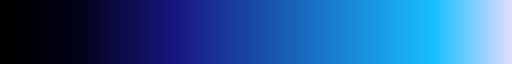

In [46]:
tmap = drawer.make_cmap(
    [[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 132/255], [25/255, 191/255, 255/255], [222/255, 222/255, 255/255]], 
    position=[0, 0.15, 0.35,0.85,1])
cmap_cold = tmap
tmap

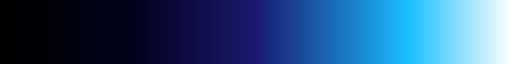

In [43]:
drawer.make_cmap([[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 112/255], [25/255, 191/255, 255/255], [255/255, 255/255, 255/255]], position=[0, 0.25, 0.5,0.8,1])

Cold Gas:   0%|          | 0/22541346 [00:00<?, ?it/s]

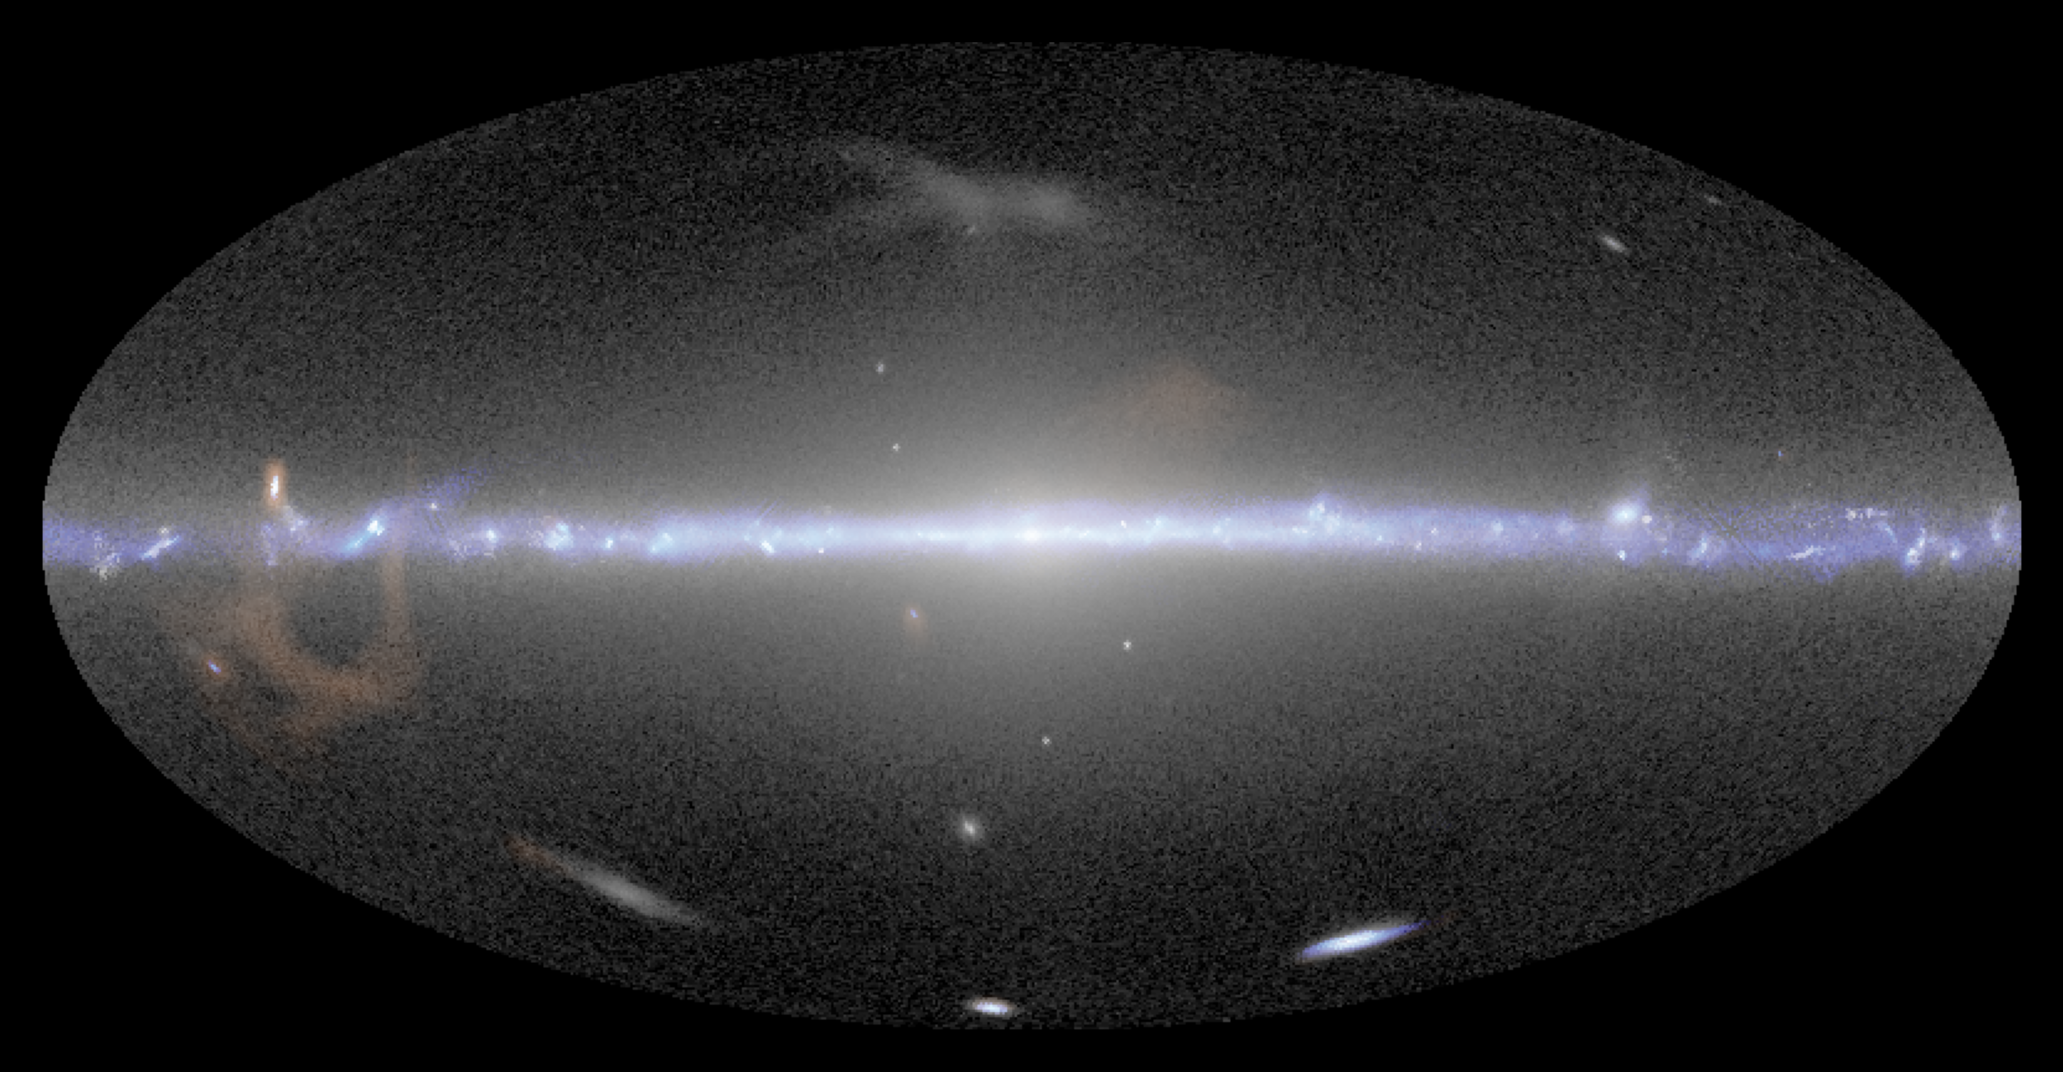

In [51]:
if(drawgas):
    if(drawcold):
        mask = (T<2e4)
        # indices = hp.ang2pix(nside, np.pi/2 - DEC[~mask], RA[~mask]) 
        # hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
        # for m, ind in tqdm(zip(M[~mask], indices), total=np.sum(~mask), desc='Hot Gas'):
        #     hpxmap[ind] += m 
        # im_cell = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
        # im_cell = gaussian_filter(im_cell, sigma=2)
        # ims.append(im_cell); cmaps.append(cmap_cell); qscales.append(1.8); vmaxs.append(np.nanmax(im_cell)*8)
        # plt.close()
        
        indices = hp.ang2pix(nside, np.pi/2 - DEC[mask], RA[mask]) 
        hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
        for m, ind in tqdm(zip(M[mask], indices), total=np.sum(mask), desc='Cold Gas'):
            hpxmap[ind] += m 
        im_cold = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
        ims.append(im_cold); cmaps.append(cmap_cold); qscales.append(3); vmaxs.append(np.nanmax(im_cold)/2)
        plt.close()
    else:
        indices = hp.ang2pix(nside, np.pi/2 - DEC, RA) 
        hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float64)
        for m, ind in tqdm(zip(M, indices), total=len(M), desc='Gas'):
            hpxmap[ind] += m 
        im_cell = hp.mollview(hpxmap, coord=['C'], return_projected_map=True)
        im_cell = gaussian_filter(im_cell, sigma=2)
        plt.close()
        ims.append(im_cell); cmaps.append(cmap_cell); qscales.append(2); vmaxs.append(np.nanmax(im_cell))


composite = painter.composite_image(
        ims, 
        cmaps=cmaps,
        qscales=qscales,
        mode='screen',
        vmaxs = vmaxs
        )
fig,ax = fancy_axis(dpi=400)
ax.imshow(composite)
fig.set_facecolor('black')
plt.show()

ims = ims[:2]
cmaps = cmaps[:2]
qscales = qscales[:2]
vmaxs = vmaxs[:2]

In [23]:
for key in LG.keys():
    if(key!=8): continue
    print(key)
    img = show_mollview(key, LG, snap, center=8, nside=128, drawsat=False, drawgas=True, drawcold=True, reverse=False, cic=True)
    fig,ax = fancy_axis(dpi=400)
    ax.imshow(img)
    fig.set_facecolor('black')
    plt.show()
    stop()
    # plt.savefig(f"{database}/photo/04_mollview/moll_{key:04d}.png", dpi=400, facecolor='k', transparent=True, bbox_inches='tight', pad_inches=0)
    # plt.close()

8


Stars:   0%|          | 0/9809456 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 